In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision import transforms

from src.data_utils import StyledMNISTGenerator, StyledMNIST
import src.corruptions as corruptions
from src.model import VAE
from src.trainer import VAETrainer

%load_ext autoreload
%autoreload 2

In [7]:
import mlflow

In [2]:
mnist = MNIST("./data", train=True, download=False)

In [3]:
generator = StyledMNISTGenerator(
    mnist,
    {
        corruptions.identity: 0.1,
        corruptions.stripe: 0.15,
        corruptions.zigzag: 0.25,
        corruptions.canny_edges: 0.15,
        lambda x: corruptions.scale(x, 5): 0.15,
        corruptions.brightness: 0.2
    },
)
dataset = StyledMNIST(
    generator, 
    transforms.Compose([
        transforms.ToTensor(), 
        lambda img: img / 255.0,
    ])
)

train, test, valid = random_split(dataset, [40000, 10000, 10000])

Generating dataset: 100%|██████████| 60000/60000 [00:15<00:00, 3763.46item/s]


In [19]:
vae = VAE(16, nc=1).to("cuda")

In [20]:
trainer = VAETrainer(
    model=vae,
    optimizer=torch.optim.Adam(vae.parameters(), lr=1e-4),
    verbose_period=1,
    device="cuda",
)

In [21]:
train_loader = DataLoader(train, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid, batch_size=128, shuffle=False)


In [31]:
import numpy as np
from mlflow.types import Schema, TensorSpec
from mlflow.models import ModelSignature

In [35]:
params = {
    "lr": 1e-4,
    "optimizer": "Adam",
    "batch_size": 128,
    "z_dim": 16,
}

input_schema = Schema([TensorSpec(np.dtype(np.float32), [-1, 1, 32, 32])])
output_schema = Schema([TensorSpec(np.dtype(np.float32), [-1, 1, 32, 32])])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

In [38]:
mlflow.set_tracking_uri("./mlruns")
mlflow.set_experiment("resnet-test")
with mlflow.start_run(run_name="resnet001"):
    mlflow.log_params(params)
    trainer.fit(epochs=1, train_loader=train_loader, valid_loader=valid_loader)
    mlflow.pytorch.log_model(trainer.model, "model", signature=signature)

val-epoch 0: 100%|██████████| 79/79 [00:02<00:00, 36.12it/s]


val_recontr_loss=32.624, val_kl=6.915


2025/06/08 15:57:11 WARNING mlflow.utils.requirements_utils: Found torch version (2.2.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.2.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/08 15:57:14 WARNING mlflow.utils.requirements_utils: Found torch version (2.2.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.2.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [34]:
test_loader = DataLoader(test, batch_size=128, shuffle=False)
trainer.evaluate(test_loader, True, 0)

val-epoch 0: 100%|██████████| 79/79 [00:01<00:00, 41.69it/s]

val_recontr_loss=32.306, val_kl=6.866


(32.30624771118164, 6.865987777709961)

In [37]:
mlflow.pytorch.load_model('runs:/e86b08ad4dc14a75b5be44b39d175e4d/model')

VAE(
  (encoder): ResNet18Enc(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlockEnc(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlockEnc(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    

In [40]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

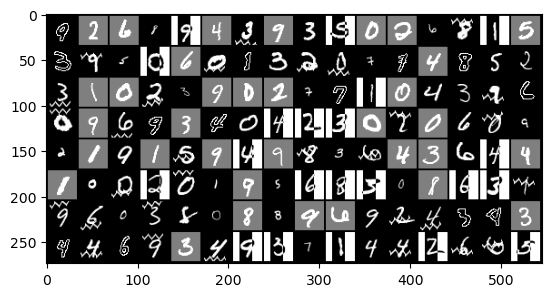

In [54]:
x = next(iter(train_loader))[0].to("cuda")
plt.imshow(make_grid(x, nrow=16).cpu().permute(1,2,0))

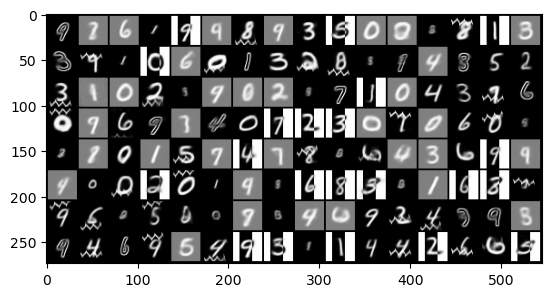

In [55]:
with torch.no_grad():
    xhat = vae(x)[0]
    plt.imshow(make_grid(xhat, nrow=16).cpu().permute(1,2,0))